In [1]:
import numpy as np

In [2]:
from shapely import wkt

In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 1. Cargamos los .json a DataFrames

In [4]:
sucursales = pd.read_json('dataset/sucursales.json', lines=True)
precios = pd.read_json('dataset/precios.json', lines=True)
productos = pd.read_json('dataset/productos.json', lines=True)

## 2. Corregimos errores de loading de los datos

In [5]:
precios["fecha"]=list(map(lambda x: x["$date"],precios["fecha"]))
precios["_id"]=list(map(lambda x: x["$oid"],precios["_id"]))
productos["_id"]=list(map(lambda x: x["$oid"],productos["_id"]))
sucursales["_id"]=list(map(lambda x: x["$oid"],sucursales["_id"]))

## 3. Desglosamos la fecha en año, mes, dia y semana

In [6]:
precios["year"] = pd.DatetimeIndex(precios["fecha"]).year
precios["month"] = pd.DatetimeIndex(precios["fecha"]).month
precios["day"] = pd.DatetimeIndex(precios["fecha"]).day
precios["week"] = pd.DatetimeIndex(precios["fecha"]).week

## 4. Unificamos los datos en un DataFrame

In [7]:
precio_producto=precios.merge(productos,left_on='producto',right_on='id')

In [8]:
precio_producto_sucursal = precio_producto.merge(sucursales,left_on='sucursal',right_on='id')

In [9]:
barrios = pd.read_csv("barrios.csv")

In [10]:
mapa = gpd.read_file("./mapa-manzanas/manzanas.shp")

In [11]:
barrio_mapa = gpd.read_file("./barrios/barrios_badata.shp")

In [14]:
barrios["barrio"] = barrios["barrio"].str.lower()

In [15]:
barrios["WKT"] = barrios["WKT"].apply(wkt.loads)

In [16]:
geometria = [Point(xy) for xy in zip(sucursales.lng,sucursales.lat)]

In [17]:
crs = {"init":"epsg:4326"}

In [18]:
geo_df = gpd.GeoDataFrame(sucursales,crs=crs,geometry=geometria)

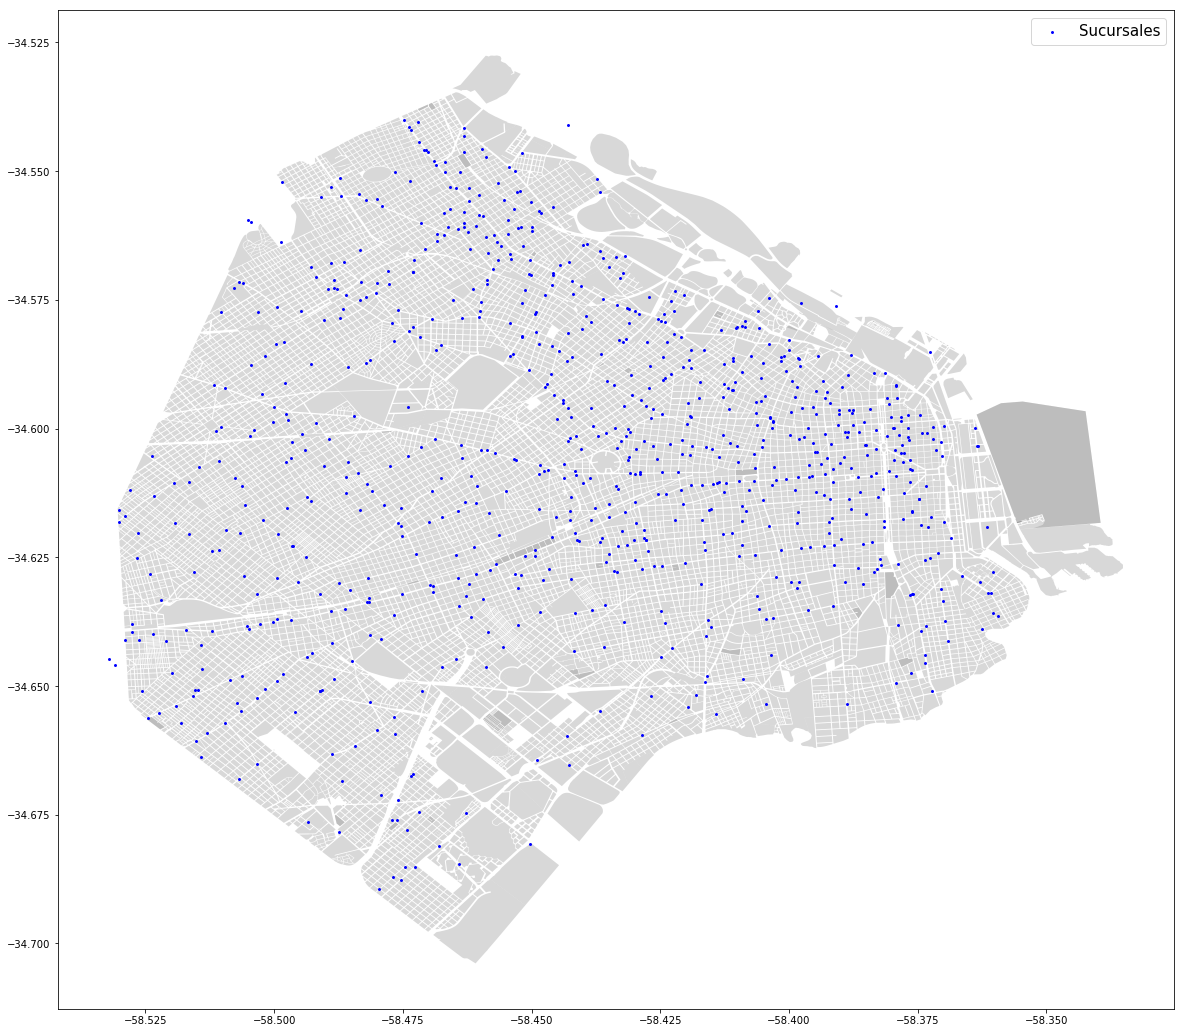

In [19]:
fig, ax = plt.subplots(figsize = (20,20))
mapa.plot(color='grey', ax=ax, alpha = 0.3)
geo_df.plot(marker='.', color='blue', markersize=15, ax=ax, label = 'Sucursales')
plt.legend(prop={'size':15})

In [20]:
undifined_points = geo_df[geo_df.localidad.str.lower().isin(["capital federal", 
                                          "ciudad autónoma de buenos aires",
                                          "ciudad autonoma de buenos aires",
                                          "ciudad autonoma buenos aires",
                                          "cap. federal",
                                          "capital",
                                          "cap. fed.",
                                          "cdad. de bs.as",
                                          "cap. fed","cap.fed"])][["id","geometry"]]

## Aca se hace magia. Asiganmos correctamente los barrios a los que pertenece la sucursal

In [21]:
pnts = gpd.GeoDataFrame(geometry=undifined_points.geometry.values, index=undifined_points.id.values)
for row in barrios[["barrio","WKT"]].values:
    for point_id, value in pnts.within(row[1]).iteritems():
        if value == True:
            sucursales.loc[sucursales.id==point_id,"localidad"]=row[0]

In [22]:
sucursales.localidad.str.lower().unique()

array(['saavedra', 'nuñez', 'villa pueyrredon', 'coghlan',
       'villa urquiza', 'belgrano', 'villa devoto', 'agronomia',
       'villa real', 'villa ortuzar', 'parque chas', 'villa del parque',
       'colegiales', 'devoto', 'palermo', 'monte castro', 'versalles',
       'paternal', 'chacarita', 'villa luro', 'villa santa rita',
       'liniers', 'villa gral. mitre', 'ciudad autonoma de buenos aires',
       'velez sarsfield', 'floresta', 'villa crespo', 'caballito',
       'flores', 'barrio norte', 'mataderos', 'recoleta', 'almagro',
       'parque avellaneda', 'abasto', 'balvanera', 'parque chacabuco',
       'retiro', 'once', 'flores sur', 'boedo', 'villa lugano',
       'tribunales', 'san nicolas', 'monserrat', 'san cristobal',
       'lugano', 'puerto madero', 'parque patricios', 'pompeya',
       'nueva pompeya', 'constitucion', 'villa soldati',
       'villa riachuelo', 'san telmo', 'v illa lugano', 'barracas',
       'boca'], dtype=object)

In [23]:
sucursales.banderaDescripcion.value_counts()

Supermercados DIA         332
Express                   292
COTO CICSA                 65
Market                     33
Disco                      26
Axion Energy               23
DEHEZA S.A.I.C.F. e I.     16
FULL                       15
Vea                        12
Jumbo                      10
Hipermercado Carrefour      9
Walmart SuperCenter         1
Mi Changomas                1
JOSIMAR SUPERMERCADOS       1
ESTACION LIMA S.A.          1
Name: banderaDescripcion, dtype: int64